In [1]:
from TradeGenerator import *
import matplotlib.pyplot as plt

In [2]:
file_name="rawTrade.csv"
import os.path
import pandas as pds
numOfClusters=5

In [3]:
if( os.path.isfile(file_name)  ):
    rawdf = pds.read_csv(file_name)
else:
    t = TradeGenerator()
    tList = t.prepareTradeList(tradingdays=360)
    rawdf = t.tradeListConvert2DataFrame(tList)
    rawdf.to_csv(file_name,index=False)
    

rawdf["total"] = rawdf["price"] * rawdf["quantity"]
df=rawdf

df=df.drop("tradeId",axis=1)

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from IPython.core.debugger import set_trace

class CategoryEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, attribute): # no *args or **kargs
        self.attribute = attribute
    def fit(self, X):
        return self  # nothing else to do
    def transform(self, X, y=None):
        #set_trace()
        _encoded, _categories = X[self.attribute].factorize()
        self.categoriesIndex = _categories
        X[self.attribute+"_cat"] = _encoded
        X.drop(self.attribute,axis=1 ,inplace=True)
        return X
        

In [5]:
from sklearn.preprocessing import StandardScaler
OrgTypeCategoryEncoder = CategoryEncoder("orgType")
CustCategoryEncoder = CategoryEncoder("cust")
SecCategoryEncoder = CategoryEncoder("secid")
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('OrgType', OrgTypeCategoryEncoder),
        ('Cust', CustCategoryEncoder),
            ('Sec', SecCategoryEncoder)
    ])

In [6]:
newdf=num_pipeline.fit_transform(df)

In [7]:
secIdInx = newdf["secid_cat"]
newdf = newdf.drop("secid_cat",axis=1)

In [8]:
newdf[(newdf["day"]<2) ].head()

,day,price,quantity,total,orgType_cat,cust_cat
0,0,98,5817950,570159100,0,0
1,1,111,8967678,995412258,1,0
360,0,93,3147146,292684578,1,1
361,1,102,9259788,944498376,1,1
720,0,118,3489053,411708254,1,2


In [9]:
trainXdf = newdf[(newdf["day"]<300) ]
trainYdf = newdf[(newdf["day"]>=300)]

In [10]:
trainXdf=trainXdf.drop("day",axis=1)
trainYdf = trainYdf.drop("day",axis=1)

In [11]:
trainYdf.head()

,price,quantity,total,orgType_cat,cust_cat
300,111,8539463,947880393,1,0
301,102,6204221,632830542,1,0
302,115,9572428,1100829220,1,0
303,97,3854309,373867973,1,0
304,100,8074704,807470400,1,0


(row,col)=trainXdf.shape
data = np.zeros((len(CustCategoryEncoder.categoriesIndex),col), dtype=np.float32)
for c in range(len(CustCategoryEncoder.categoriesIndex)):
    custClassSet = trainXdf[ trainXdf["cust_cat"] ==c ]
    
    for j in range(0,col):
        data[c,j] = np.round(np.sum( custClassSet[custClassSet["orgType_cat"]==j]["total"] )/1000000)


In [12]:
def generateFeatures(tradeData,scale,custCategory):
    (row,col)=tradeData.shape
    data = np.zeros((len(custCategory.categoriesIndex),col), dtype=np.float32)
    for c in range(len(custCategory.categoriesIndex)):
        custClassSet = tradeData[ tradeData["cust_cat"] ==c ]
        for j in range(0,col):
            data[c,j] = np.round(np.sum( custClassSet[custClassSet["orgType_cat"]==j]["total"] )/scale)
    return data

In [22]:
traindata = generateFeatures(trainXdf,1000000,CustCategoryEncoder)
trainLabelData = generateFeatures(trainYdf,1000000,CustCategoryEncoder)

In [14]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=numOfClusters, random_state=0).fit(traindata)

In [15]:
ll=pd.DataFrame(kmeans.labels_)

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

def plot2DCluster(kmeans,data,xaxis,yaxis,axisIndex,subplot=111):
    ll=pd.DataFrame(kmeans.labels_)
    numOfCluster = kmeans.n_clusters
    
    plt.subplot(subplot)
    colors = cm.rainbow(np.linspace(0, 1, numOfCluster))
    for c in range(0,numOfCluster):
        d = data[ll[0]==c]
        plt.scatter(d[:,xaxis],d[:,yaxis],c=colors[c],marker="o")
        plt.scatter(kmeans.cluster_centers_[c,xaxis],kmeans.cluster_centers_[c,yaxis],c=colors[c],marker="x")
        
    # rotate the axes and update
    plt.xlabel(axisIndex[xaxis], fontsize=14)
    plt.ylabel(axisIndex[yaxis], fontsize=14)
    #ax.set_zlabel("restaurant", fontsize=14)
    

def plot3DCluster(kmeans,data,xaxis,yaxis,zaxis,axisIndex):
    ll=pd.DataFrame(kmeans.labels_)
    numOfCluster = kmeans.n_clusters
    
   
    ax = Axes3D(fig)
    colors = cm.rainbow(np.linspace(0, 1, numOfCluster))
    for c in range(0,numOfCluster):
        d = data[ll[0]==c] #select the data of cluster
        ax.scatter(d[:,xaxis],d[:,yaxis],d[:,zaxis],c=colors[c],marker="o")
        ax.scatter(kmeans.cluster_centers_[c,xaxis],kmeans.cluster_centers_[c,yaxis],kmeans.cluster_centers_[c,zaxis],c=colors[c],marker="x")
        
    # rotate the axes and update
    ax.set_xlabel(axisIndex[xaxis], fontsize=14)
    ax.set_ylabel(axisIndex[yaxis], fontsize=14)
    ax.set_zlabel(axisIndex[zaxis], fontsize=14)
    #plt.show()

In [17]:
OrgTypeCategoryEncoder.categoriesIndex

Index(['airline', 'Gov', 'tech', 'energy', 'restaurant'], dtype='object')

In [18]:
kmeans.cluster_centers_

array([[   2102.99951172,  142811.3125    ,    7131.68798828,
          15654.93847656,    4252.4375    ],
       [    875.49975586,  146550.59375   ,   22151.2734375 ,
           4147.86425781,    1355.27319336],
       [   4948.36816406,  147344.46875   ,   11411.2109375 ,
           8455.26367188,    1932.3684082 ],
       [   3336.75      ,  144681.75      ,    9846.1875    ,
           2307.87548828,   12987.68554688],
       [   3670.62939453,  136984.921875  ,   20057.77734375,
           5565.48144531,    2867.88916016]], dtype=float32)

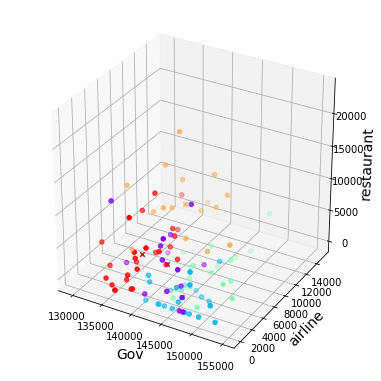

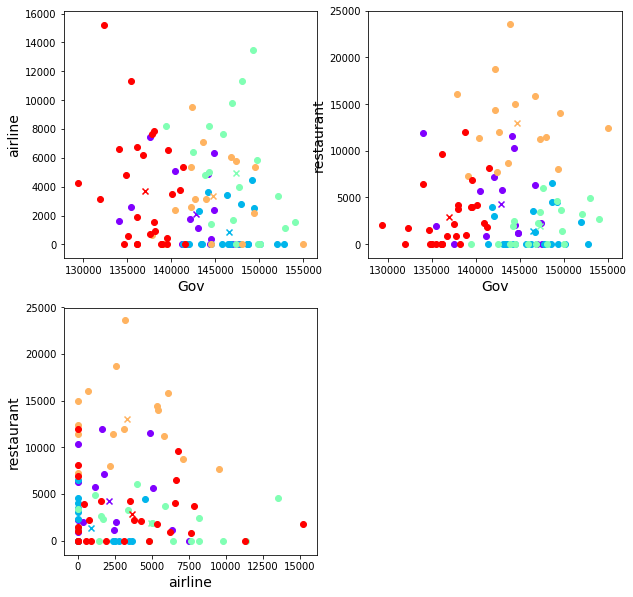

In [19]:
fig = plt.figure(figsize=(5, 5))
plot3DCluster(kmeans,traindata,1,0,4,OrgTypeCategoryEncoder.categoriesIndex)
plt.show()
fig = plt.figure(figsize=(10, 10))
plot2DCluster(kmeans,traindata,1,0,OrgTypeCategoryEncoder.categoriesIndex,221)
plot2DCluster(kmeans,traindata,1,4,OrgTypeCategoryEncoder.categoriesIndex,222)
plot2DCluster(kmeans,traindata,0,4,OrgTypeCategoryEncoder.categoriesIndex,223)
plt.show()

In [26]:
print("Cluster centre:")
cSet=np.round(kmeans.cluster_centers_[:,0:len(OrgTypeCategoryEncoder.categoriesIndex)])
ClusterCenter = pds.DataFrame(cSet, columns=OrgTypeCategoryEncoder.categoriesIndex)
ClusterCenter

Cluster centre:


,airline,Gov,tech,energy,restaurant
0,2103.0,142811.0,7132.0,15655.0,4252.0
1,875.0,146551.0,22151.0,4148.0,1355.0
2,4948.0,147344.0,11411.0,8455.0,1932.0
3,3337.0,144682.0,9846.0,2308.0,12988.0
4,3671.0,136985.0,20058.0,5565.0,2868.0


In [27]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(traindata, trainLabelData)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [31]:
tree_reg.predict(traindata[0].reshape(1,-1))

array([[     0.,  28958.,      0.,   6719.,      0.]])

In [40]:
tree_reg.score

<bound method RegressorMixin.score of DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')>